# Creating Embeddings

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#### Loading custom functions

In [6]:
# We load custom functions from a python file
#function 1 to clean and standardizes raw text before further NLP processing (lowercasing, removing punctuation, stopwords, etc.)
#function 2 to create a dictionary of unique words in the dataset and assign an index to each word 
# (required for embeddings, one-hot encoding)
from extra.utility import text_preprocessing, create_unique_word_dict

### Read data

In [7]:
# Reading the text from the input folder
texts = pd.read_csv('data/sample.csv')
texts = [x for x in texts['text']]
texts

['The future king is the prince',
 'Daughter is the princess ',
 'Son is the prince',
 'Only a man can be a king ',
 'Only a woman can be a queen',
 'The princess will be a queen',
 'Queen and king rule the realm',
 'The prince is a strong man',
 'The princess is a beautiful woman ',
 'The royal family is the king and queen and their children',
 'Prince is only a boy now',
 'A boy will be a man']

Setting `window=2` to create pairs of 2 words occurring together in the dataset.

In [8]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

- We go through all the sentences in the dataset. Preprocess the sentences (tokenize and remove stop words)
- We then create pair of words which occur near to each other in a window size equal 2.
  - A pair is created for two words say `a` and `b` like `a,b` and `b,a`

In [ ]:
# Goal: Build a dataset of (center_word, context_word) pairs for learning word embeddings.
# Iterating over every text in the dataset
for text in texts:

    # Apply preprocessing (tokenization, lowercasing, removing stopwords/punctuation, etc.)
    # afterwards, text is a list of tokens, e.g., "This is a sample text" becomes ['sample', 'text']
    text = text_preprocessing(text)

    # Appending to the all text list (Adds the tokens from this document to a global list of all words)
    all_text += text 

    # Creating a context dictionary
    # i → index of the current word in the text
	# word → current word
	# w → distance from the current word (0 to window-1)
	# Purpose: look ahead and behind up to window words to get context.
    for i, word in enumerate(text):
        for w in range(window):
            # Checks if a word ahead exists within bounds
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Checks if a word behind exists within bounds
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])


> This code slides a window over each sentence to capture “who co-occurs with whom”, which is exactly how Word2Vec learns that similar words appear in similar contexts.

In [10]:
word_lists

[['future', 'king'],
 ['future', 'prince'],
 ['king', 'prince'],
 ['king', 'future'],
 ['prince', 'king'],
 ['prince', 'future'],
 ['daughter', 'princess'],
 ['princess', 'daughter'],
 ['son', 'prince'],
 ['prince', 'son'],
 ['only', 'man'],
 ['only', 'can'],
 ['man', 'can'],
 ['man', 'only'],
 ['man', 'king'],
 ['can', 'king'],
 ['can', 'man'],
 ['can', 'only'],
 ['king', 'can'],
 ['king', 'man'],
 ['only', 'woman'],
 ['only', 'can'],
 ['woman', 'can'],
 ['woman', 'only'],
 ['woman', 'queen'],
 ['can', 'queen'],
 ['can', 'woman'],
 ['can', 'only'],
 ['queen', 'can'],
 ['queen', 'woman'],
 ['princess', 'queen'],
 ['queen', 'princess'],
 ['queen', 'king'],
 ['queen', 'rule'],
 ['king', 'rule'],
 ['king', 'queen'],
 ['king', 'realm'],
 ['rule', 'realm'],
 ['rule', 'king'],
 ['rule', 'queen'],
 ['realm', 'rule'],
 ['realm', 'king'],
 ['prince', 'strong'],
 ['prince', 'man'],
 ['strong', 'man'],
 ['strong', 'prince'],
 ['man', 'strong'],
 ['man', 'prince'],
 ['princess', 'beautiful'],
 ['p

Taking out all the unique words from our dataset

In [11]:
unique_word_dict = create_unique_word_dict(all_text)

In [12]:
unique_word_dict

{'beautiful': 0,
 'boy': 1,
 'can': 2,
 'children': 3,
 'daughter': 4,
 'family': 5,
 'future': 6,
 'king': 7,
 'man': 8,
 'now': 9,
 'only': 10,
 'prince': 11,
 'princess': 12,
 'queen': 13,
 'realm': 14,
 'royal': 15,
 'rule': 16,
 'son': 17,
 'strong': 18,
 'their': 19,
 'woman': 20}

In [13]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

Neural networks require numeric vectors, not strings.


In [ ]:
# Creating the X and Y (training) matrices using one hot encoding
X = [] # X → input vectors (main words)
Y = [] # Y → target vectors (context words)

# Iterating over the word lists to create the one hot encoded vectors for X and Y
# tqdm is used to show a progress bar during the iteration, which can be helpful for large datasets to monitor the progress
for i, word_list in tqdm(enumerate(word_lists)):

    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the empty (one-hot) placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    # e.g. this vector represents the word "sample" in a vocabulary of 5 words: [0, 1, 0, 0, 0] 
    # (assuming "sample" is the second word in the unique word list)
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    # e.g. this vector represents the word "text" in a vocabulary of 5 words: [0, 0, 0, 1, 0]
    Y_row[context_word_index] = 1

    # Appending to the main matrices, store the one-hot encoded vectors for the main word and context word in X and Y respectively
    X.append(X_row)
    Y.append(Y_row)

84it [00:00, 84509.84it/s]


In [15]:
# converting lists to Numpy arrays
X = np.asarray(X)
Y = np.asarray(Y)


In [23]:
# Defining the size of the embedding
embed_size = 3

We build a 1 layer Neural network, with an `input dimension = total number of unique words`, which represents our vocabulary. And the `output dimension = size of vocabulary` to get the embeddings for each word of same dimension.

In [24]:
# Defining the neural network
model = Sequential()

# layers
model.add(Dense(units = embed_size, activation = 'linear', input_dim = X.shape[1]))
model.add(Dense(units = Y.shape[1], activation = 'softmax'))


# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
print(model.summary())

/Users/ivokafemann/Library/Mobile Documents/com~apple~CloudDocs/Documents/Bildung/Onlinekurse/AI Engineering/Week 10/ds-intro-NLP-ivk/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 3)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150 (600.00 B)

 Trainable params: 150 (600.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [25]:

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 3.0683
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0670
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0657
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0644
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0632
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0619
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0606
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0594
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0581
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0568
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0556
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0543
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0531
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0518
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0506
Epo

After training the network, we extract the trained weights from the first layer of the neural network, which will be the embeddings for our vocabulary

In [19]:
# The input layer 
weights = model.get_weights()[0]

In [20]:
# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

#### 2D visualization

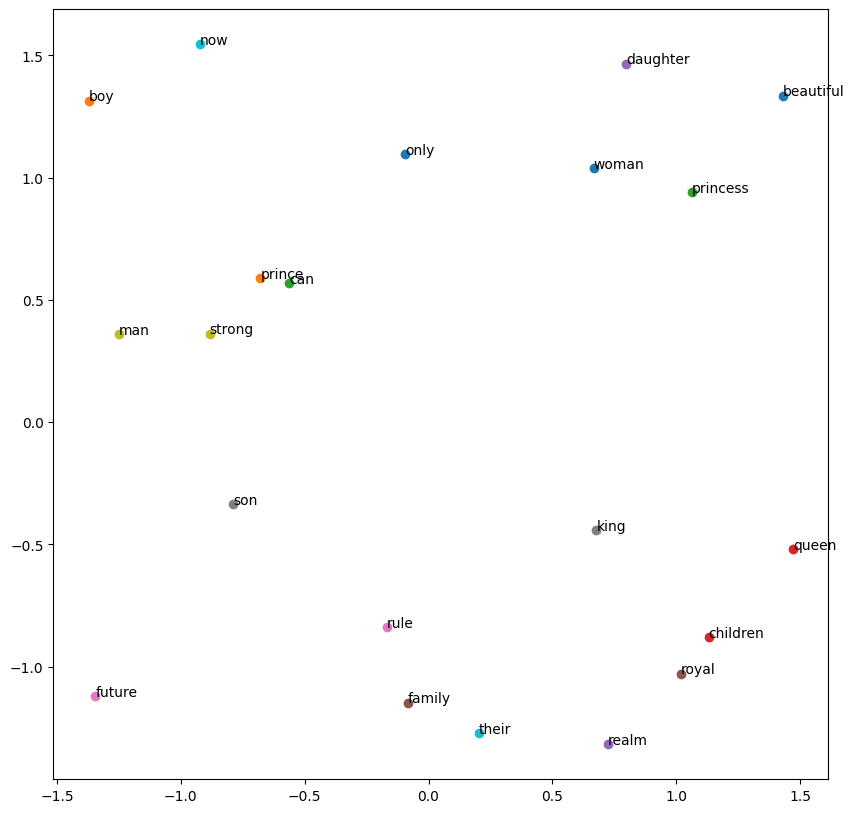

In [21]:
# Plotting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       


#### Visualization in 3D

We can also visualize the embeddings in 3-dimensions. For this, change the `embed_size` to `3` by scrolling 5-6 cells above and running the cells again. Also Uncomment the code cell below to visualize embeddings in 3D

IndexError: index 2 is out of bounds for axis 0 with size 2

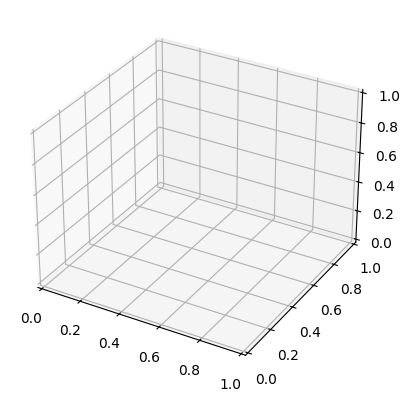

<Figure size 1000x1000 with 0 Axes>

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plotting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    ax.scatter(coord[0], coord[1],coord[2])
    ax.text(coord[0], coord[1], coord[2],word)    

In [ ]:
# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}//embeddings_output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

In [ ]:
with open(f'{os.getcwd()}//embeddings_output//embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}') 

 - These embeddings are later used on a large scale as an Embedding layer in different neural networks trained for NLP tasks <br> 
 - As we increase the embedding size, i.e., the size of the vector for each word in the vocabulary, the more accurate we get the results. <br> 
 - Try changing the embedding size to 3 (but the plot will have to be 3D then). Try plotting it on the same 2D scatter plot and notice if there are any differences.